<a href="https://colab.research.google.com/github/MaryZolfaghar/PredictiveEpisodicControl/blob/master/Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize results of experiments
### Final figures will be saved in the 'figures' folder

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS,TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [28]:
import torch
from models.VAE import VAE
from environments.FourRooms import FourRooms

Creating an environment with 9 cells in each room.
Each cell is representing a random number from mnist dataset

In [29]:
room_size = 9
env = FourRooms(room_size,'mnist')

In [30]:
gamma = 0.99

## State Representation
### Figure 2. (left)

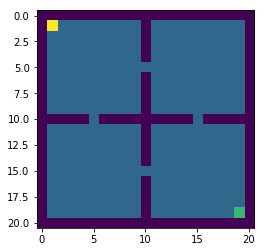

In [31]:
env.render()
plt.show()

## Find true SR with dynamic programming

In [32]:
# Use this to ensure same order every time
idx_to_state = {i:state for i,state in enumerate(env.state_dict.keys())}
state_to_idx = {v:k for k,v in idx_to_state.items()}

Build a transition matrix

In [33]:
T = np.zeros([env.n_states,env.n_states])
for i,s in idx_to_state.items():
    for a in range(4):
        env.state = s
        _,_,_,_ = env.step(a)
        s_tp1 = env.state
        T[state_to_idx[s],state_to_idx[s_tp1]] += 0.25

In [34]:
def visualize_fourrooms_matrix(env,T,s):
    im_side = 2*env.room_size + 3
    T_image = np.zeros([im_side,im_side])
    s_x,s_y = s
    s_idx = state_to_idx[(s_x,s_y)]
    for x in range(im_side):
        for y in range(im_side):
            if (x,y) not in env.state_dict:
                T_image[x,y] = 0
            else:
                idx = state_to_idx[(x,y)]
                T_image[x,y] = T[s_idx,idx]
    return T_image

Build true SR matrix

In [35]:
theta = 1e-10
true_SR = np.zeros([env.n_states,env.n_states])
done = False
while not done:
    new_SR = np.matmul(T,np.eye(env.n_states)+gamma*true_SR)
    diff = np.max(np.abs(true_SR - new_SR))
    done =  diff < theta
    true_SR = new_SR

## Visualize the true SR representation
### Figure 2. (right)

In [36]:
from sklearn.neighbors.kd_tree import KDTree

In [37]:
state = (17,9)
k = 80

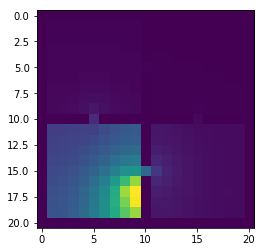

In [38]:
SR_image = visualize_fourrooms_matrix(env,true_SR,state)
plt.imshow(SR_image)
plt.show()

## Loading saved data and visualize results
The running time for our project is ~1 day. Therefore for the sake of visualization we have uploaded the saved weights and data 

VAE
* Input: mnist image with size 28 X 28
* Output: embedding representation with size 32 X 1
* Upload the trained VAE 

In [39]:
in_channels = 1
embedding_size = 32
in_height = 28
in_width = 28
vae = VAE(in_channels,embedding_size,in_height,in_width)
vae.load_state_dict(torch.load('../weights/VAE/VAE_rooms_mnist.pt'))

<All keys matched successfully>

Calulate the state embedding representation using the trained VAE encoder

In [40]:
n_states = env.n_states
VAE_reps = np.zeros([n_states,embedding_size])
VAE_labels = []
for i,(state,obs) in enumerate(env.state_dict.items()):
    obs = torch.tensor(obs).permute(2,0,1) #(H,W,C)->(C,H,W)
    obs = obs.unsqueeze(0)
    with torch.no_grad():
        mu, logvar = vae.encoder(obs)
        state_embedding = torch.cat([mu, logvar],1)
        state_embedding = state_embedding.squeeze()
        state_embedding = state_embedding.cpu().numpy()
    VAE_reps[i,:] = state_embedding
    # different label for each room
    if state[0] < room_size + 1 and state[1] < room_size + 1:
        label = 0
    elif state[0] > room_size + 1 and state[1] < room_size + 1:
        label = 1
    elif state[0] < room_size + 1 and state[1] > room_size + 1:
        label = 2
    elif state[0] > room_size + 1 and state[1] > room_size + 1:
        label = 3
    else:
        label = 4
    VAE_labels.append(label)

## Visualize training results
### Figure 3

In [41]:
rand_3knn = np.load('../results/MFEC/MFEC_rand_rooms_mnist_3knn.npy')
VAE_3knn = np.load('../results/MFEC/MFEC_VAE_rooms_mnist_3knn.npy')
SR_DP_3knn = np.load('../results/MFEC_SR/MFEC_SR_rand_DP_rooms_mnist_3knn.npy')
SR_TD_3knn = np.load('../results/MFEC_SR/MFEC_SR_rand_TD_rooms_mnist_200epochs_3knn.npy')

In [42]:
window = 100
smoothed_rand_3knn = np.convolve(rand_3knn[:,2], np.ones((window,))/window, mode='valid')
smoothed_VAE_3knn = np.convolve(VAE_3knn[:,2], np.ones((window,))/window, mode='valid')
smoothed_SR_DP_3knn = np.convolve(SR_DP_3knn[:,2], np.ones((window,))/window, mode='valid')
smoothed_SR_TD_3knn = np.convolve(SR_TD_3knn[:,2], np.ones((window,))/window, mode='valid')

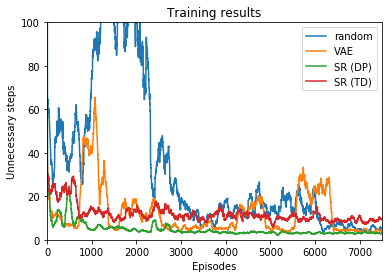

In [43]:
plt.plot(smoothed_rand_3knn)
plt.plot(smoothed_VAE_3knn)
plt.plot(smoothed_SR_DP_3knn)
plt.plot(smoothed_SR_TD_3knn)
plt.title("Training results")
plt.xlabel("Episodes")
plt.ylabel("Unnecessary steps")
plt.xlim([0,7500]) # The model was trained for 20000 but here we only plotted the first part for simplicity
plt.ylim([0,100])
plt.legend(["random","VAE","SR (DP)", "SR (TD)"])
plt.savefig("figures/train_curves.png",bbox_inches = 'tight',pad_inches = 0,dpi=100)
plt.show()

Average number of extra steps throughout training:

In [44]:
print("Random:", np.mean(rand_3knn[:7500,2]))
print("VAE:", np.mean(VAE_3knn[:7500,2]))
print("SR (DP):", np.mean(SR_DP_3knn[:7500,2]))    
print("SR (TD):", np.mean(SR_TD_3knn[:7500,2]))  

Random: 35.217866666666666
VAE: 12.92
SR (DP): 8.163733333333333
SR (TD): 12.6072


Average number of extra steps in the last 100 episodes

In [45]:
print("Random:", np.mean(rand_3knn[7400:7500,2]))
print("VAE:", np.mean(VAE_3knn[7400:7500,2]))
print("SR (DP):", np.mean(SR_DP_3knn[7400:7500,2]))    
print("SR (TD):", np.mean(SR_TD_3knn[7400:7500,2]))  

Random: 4.3
VAE: 4.46
SR (DP): 3.24
SR (TD): 9.21


## Multidimensional scaling plots to visualize representations of each type of embedding

In [46]:
colors = ['green','blue','red','purple','orange']

Loading the saved representational results and their corresponding labels

In [47]:
emb_reps = np.load('../results/MFEC_SR/random_TD_mnist_200epochs_3knn_emb_reps.npy')
SR_reps = np.load('../results/MFEC_SR/random_TD_mnist_200epochs_3knn_SR_reps.npy')
labels = np.load('../results/MFEC_SR/random_TD_mnist_200epochs_3knn_labels.npy')

## Visualize Random Representations
### Figure 4. (top-left)

In [48]:
mds_emb = MDS(n_components=2)
mds_emb_2d = mds_emb.fit_transform(emb_reps)

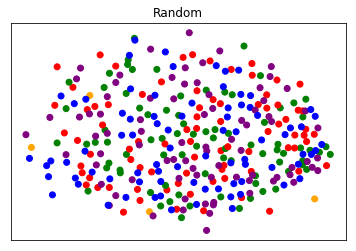

In [49]:
plt.scatter(mds_emb_2d[:,0],mds_emb_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("Random")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/mds_rand.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

## Visualize VAE Representation
### Figure 4. (top-right)

We have represented multidimensional scaling of VAE, random and SR representation

In [50]:
mds_vae = MDS(n_components=2)
mds_vae_2d = mds_vae.fit_transform(VAE_reps)

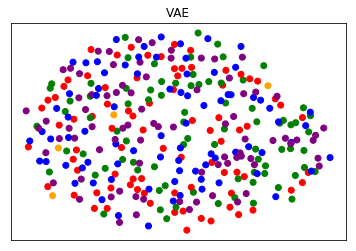

In [51]:
plt.scatter(mds_vae_2d[:,0],mds_vae_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("VAE")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/mds_VAE.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

## Visualize SR Representation
### Figure 4. (bottom-left)

In [65]:
# Get true SR of embeddings by matrix-multiplying SR by embedding matrix
true_SR_reps = np.matmul(true_SR,emb_reps)

In [66]:
true_SR_reps = true_SR_reps/np.linalg.norm(true_SR_reps,axis=1,keepdims=True)
emb_reps = emb_reps/np.linalg.norm(emb_reps,axis=1,keepdims=True)

In [67]:
mds_sr = MDS(n_components=2)
mds_sr_2d = mds_sr.fit_transform(true_SR_reps)

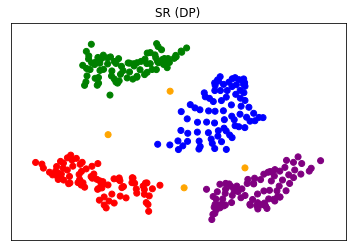

In [68]:
plt.scatter(mds_sr_2d[:,0],mds_sr_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("SR (DP)")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/mds_SR_DP.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

## Visualize SR Representation
### Figure 4. (bottom-right)

In [69]:
mds_sr = MDS(n_components=2)
mds_sr_2d = mds_sr.fit_transform(SR_reps)

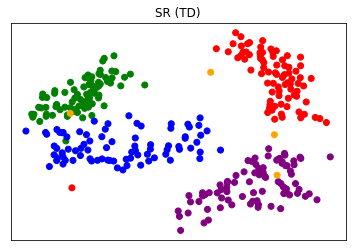

In [70]:
plt.scatter(mds_sr_2d[:,0],mds_sr_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("SR (TD)")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/mds_SR_TD.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

## Visualization of the weights assigned to each of the k-nearest neighbors by an episodic control agent
### Figure 5

In [59]:
sr_kdtree = KDTree(true_SR_reps)
emb_kdtree = KDTree(emb_reps)

In [60]:
state = (17,9)
k = 80

In [61]:
def weights(distances):
    delta = 0.01
    distances = distances/(np.sum(distances)+1e-8)
    similarities = 1 / (distances+delta)
    return similarities/np.sum(similarities)

In [62]:
state_idx = state_to_idx[state]
state_sr = true_SR_reps[state_idx,:]
sr_distances,sr_indices = sr_kdtree.query([state_sr],k=k,return_distance=True)
sr_weights = weights(sr_distances)
sr_w_matrix = np.zeros([env.n_states,env.n_states])
for sr_weight,idx in zip(sr_weights,sr_indices):
    sr_w_matrix[state_idx,idx] = sr_weight

state_emb = emb_reps[state_idx,:]
emb_distances,emb_indices = emb_kdtree.query([state_emb],k=k,return_distance=True)
emb_weights = weights(emb_distances)
emb_w_matrix = np.zeros([env.n_states,env.n_states])
for emb_weight,idx in zip(emb_weights,emb_indices):
    emb_w_matrix[state_idx,idx] = emb_weight

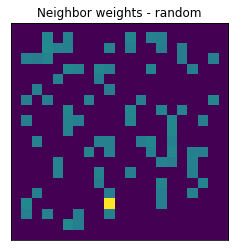

In [63]:
emb_sim_im = visualize_fourrooms_matrix(env,emb_w_matrix,state)
plt.imshow(emb_sim_im)
plt.title("Neighbor weights - random")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/random_neighbors.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

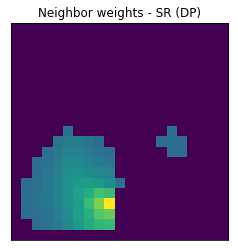

In [64]:
sr_sim_im = visualize_fourrooms_matrix(env,sr_w_matrix,state)
plt.imshow(sr_sim_im)
plt.title("Neighbor weights - SR (DP)")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/SR_DP_neighbors.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()